Reference: https://colab.research.google.com/github/infer-actively/pymdp/blob/master/docs/notebooks/active_inference_from_scratch.ipynb

In [126]:
%matplotlib widget

IMPORTS

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import seaborn as sns
from pymdp import utils
import copy
from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable

Parameters

In [ ]:

N=2
T=2000
dt=0.1
s0=1
e01=np.pi
e02=np.pi*0
eps=1e-16
alph=2
ROI=600 #region of interaction
Dia=2
gam=1 #gamma for repulsion force
S=30
isactinfinggrand=1
isplanning=1
n_iter=20

Auxillary Functions

In [129]:
def plot_pos(pos: np.ndarray,t):
    plt.scatter(pos[:,0,t],pos[:,1,t])
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f'Agents at t={t}')
    

def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

  

def plot_B_matrix(B):
    # Visualising B
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Transpose to match (z, y, x) = (Action, Current state, Next state)
    data = B #.transpose(0, 1, 2)

    # Plot voxels where data == 1
    ax.voxels(data, facecolors='skyblue', edgecolor='k')

    # Set ticks for discrete axis values
    ax.set_xticks(range(data.shape[0]))  # next state (x)
    ax.set_yticks(range(data.shape[1]))  # current state (y)
    ax.set_zticks(range(data.shape[2]))  # action (z)

    # Set labels
    ax.set_xlabel('Next state')
    ax.set_ylabel('Current state')
    ax.set_zlabel('Action')

    plt.tight_layout()
    plt.show()



Initial Conditions, t=0

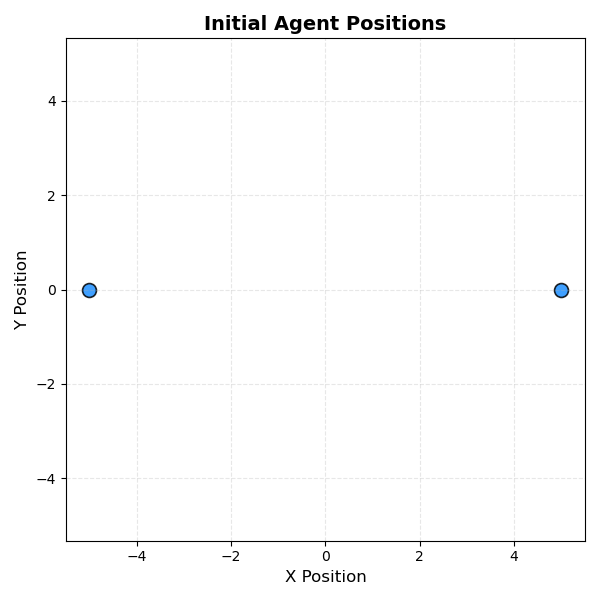

In [130]:
pos=np.zeros((N,2,T))
vel=np.zeros((N,2,T))
acc=np.zeros((N,2,T))
pref_vel=np.zeros((N,2,T)) # in speed, theta coordinets, 1st dim has speed, 2nd dim has angle
v0=np.zeros((N,2,T)) #prefered velocities in x,y coordinates
dist=np.zeros((N,N,T))

t=0
pos[0,0,t]=5
pos[0,1,t]=0
pos[1,0,t]=-5
pos[1,1,t]=0

vel[0,0,t]=0
vel[0,1,t]=0
vel[1,0,t]=0
vel[1,1,t]=0.1

pref_vel[:,0,:]=s0
pref_vel[0,1,t]=e01
pref_vel[1,0,t]=s0
pref_vel[1,1,t]=e02

# pref_vel[:,0,:]



# pos[2,0,t]=5
# pos[2,1,t]=2.5
# pos[3,0,t]=-5
# pos[3,1,t]=2.5

# R=10
# theta = np.linspace(0, 2*np.pi, N, endpoint=False)-np.pi/4
# pos[:, 0, t] = R * np.cos(theta)  # x
# pos[:, 1, t] = R * np.sin(theta)  # y

plt.figure(figsize=(6, 6))
plt.scatter(
    pos[:, 0, 0], pos[:, 1, 0],
    s=100,                          # Marker size
    c='dodgerblue',                 # Fill color
    edgecolors='k',                 # Edge color
    alpha=0.85,                     # Transparency
    linewidths=1.2                  # Edge line width
)
plt.title("Initial Agent Positions", fontsize=14, weight='bold')
plt.xlabel("X Position", fontsize=12)
plt.ylabel("Y Position", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()



## Simulation functions

In [131]:
def acc_intrinsic(vel,pref_vel,i,t):
    v0[i,:,t]=pref_vel[i,0,t]*np.round(np.array([np.cos(pref_vel[i,1,t]),np.sin(pref_vel[i,1,t])]),2)
    return -alph*(vel[i,:,t]-v0[i,:,t])

def acc_repulsive(pos,i,t):
    repulsion_term=0
    for j in range(N):
        dist[i,j,t-1]=np.sqrt(eps+(pos[i,0,t-1]-pos[j,0,t-1])**2+(pos[i,1,t-1]-pos[j,1,t-1])**2)
        if dist[i,j,t-1]>ROI:
            continue
        else:
            repulsion_term+= gam*(pos[i,:,t-1]-pos[j,:,t-1])/((dist[i,j,t-1]-Dia)**3) 
    return repulsion_term

def get_state_label(intrinsic_term,repulsion_term, debugging=False):
    d=(np.linalg.norm(repulsion_term)/(eps+np.linalg.norm(intrinsic_term))).round(1)
    if debugging:
        print(d)
        
    state_label="DESIRED" if (d <=0.05) else "MILD" if (d>0.05 and d<0.3) else "SIGNIFICANT"
    return state_label

def update_simulation(acc,vel,pos,t):
    vel[:,:,t]=vel[:,:,t-1]+(dt*acc[:,:,t])
    pos[:, :, t] = ((pos[:, :, t-1] + dt * vel[:, :, t] + S/2) % S) - S/2
    
# def polar_to_cartesian(v)

## Active Inference Functions

In [132]:

def create_B_matrix(i,t,debugging=False):
  B = np.zeros( (len(states), len(states), len(actions)) )
  pos_temp=np.copy(pos)
  vel_temp=np.copy(vel)
  acc_temp=np.copy(acc)
  pref_vel_temp=np.copy(pref_vel)
  
  
  for action_id, action_label in enumerate(actions):

    # for curr_state, state_label in enumerate(states):
          # if state_label=="DESIRED":
      if action_label=="DEFAULT":
                      
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,0]
        if debugging:
          print(pref_vel_temp[i,1,0]/np.pi)
        
        
      if action_label=="ML":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]+np.pi/4
        
      if action_label=="MR":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]-np.pi/4
        
      if action_label=="SL":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]+np.pi/2
        
      if action_label=="SR":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]-np.pi/2
              
          # if state_label=="MILD":
          #   if action_label=="DEFAULT":
              
          #   if action_label=="ML":
              
          #   if action_label=="MR":
              
          #   if action_label=="SL":
              
          #   if action_label=="SR":
              
          # if state_label=="SIGNIFICANT":
          #   if action_label=="DEFAULT":
              
          #   if action_label=="ML":
              
          #   if action_label=="MR":
              
          #   if action_label=="SL":
              
          #   if action_label=="SR":
      if debugging:     
        print(pref_vel_temp[i,:,t]/np.pi)   
      acc_temp[:,:,t]=acc_intrinsic(vel_temp,pref_vel_temp,i,t)+acc_repulsive(pos_temp,i,t-1)
      
      # for tt in range(n_iter):
      update_simulation(acc_temp,vel_temp,pos_temp,t)
      
      next_state = states.index(get_state_label(acc_intrinsic(vel_temp,pref_vel_temp,i,t),acc_repulsive(pos_temp,i,t)))
      B[next_state, :, action_id] = 1.0
  return B

""" Create an infer states function that implements the math we just discussed"""

def infer_states(observation_index, A, prior):

  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs


""" define component functions for computing expected free energy """

def get_expected_states(B, qs_current, action):
  """ Compute the expected states one step into the future, given a particular action """
  qs_u = B[:,:,action].dot(qs_current)

  return qs_u

def get_expected_observations(A, qs_u):
  """ Compute the expected observations one step into the future, given a particular action """

  qo_u = A.dot(qs_u)

  return qo_u

def entropy(A):
  """ Compute the entropy of a set of conditional distributions, i.e. one entropy value per column """

  H_A = - (A * log_stable(A)).sum(axis=0)

  return H_A

def kl_divergence(qo_u, C):
  """ Compute the Kullback-Leibler divergence between two 1-D categorical distributions"""
  
  return (log_stable(qo_u) - log_stable(C)).dot(qo_u)

def calculate_G(A, B, C, qs_current, actions):

  G = np.zeros(len(actions)) # vector of expected free energies, one per action

  H_A = entropy(A) # entropy of the observation model, P(o|s)

  for action_i in range(len(actions)):
    
    qs_u = get_expected_states(B, qs_current, action_i) # expected states, under the action we're currently looping over
    qo_u = get_expected_observations(A, qs_u)           # expected observations, under the action we're currently looping over

    pred_uncertainty = H_A.dot(qs_u) # predicted uncertainty, i.e. expected entropy of the A matrix
    pred_div = kl_divergence(qo_u, C) # predicted divergence

    G[action_i] = pred_uncertainty + pred_div # sum them together to get expected free energy
  
  return G


def action_to_pref_vel(chosen_action,i,debugging=False):
  action_label=actions[chosen_action]
  print(action_label)
  if action_label=="DEFAULT":
                      
    pref_vel[i,1,t]=pref_vel[i,1,0]

  if action_label=="ML":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]+np.pi/4

  if action_label=="MR":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]-np.pi/4

  if action_label=="SL":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]+np.pi/2

  if action_label=="SR":
    pref_vel[i,1,t]=pref_vel[i,1,t-1]-np.pi/2
  if debugging:
    print(pref_vel[i,1,t]/np.pi)
              

### Simulation Loop

In [133]:
states=["DESIRED","MILD","SIGNIFICANT"]
actions=["DEFAULT","ML","MR","SL","SR"]

n_states = len(states)
n_observations = len(states)
for t in range(1,T-1):
    for i in range(N):
        # Active Inferencing
        curr_state=get_state_label(acc_intrinsic(vel,pref_vel,i,t-1),acc_repulsive(pos,i,t))
        
        
        A = np.eye(n_observations, n_states)
        B = create_B_matrix(i,t)
        C = utils.onehot(states.index("DESIRED"),n_states)
        D = utils.onehot(states.index(curr_state), n_states)
        prior = D.copy() if t==1 else B[:,:,chosen_action].dot(qs_current) 
        obs=curr_state
        if obs=="DESIRED":
            isactinfing=0
        else:
            isactinfing=isactinfinggrand
            
        print(f'Time {t}: Agent observes itself in: {obs}')
        
        obs_idx=states.index(obs)
        
            # perform inference over hidden states
        qs_current = infer_states(obs_idx, A, prior)
        G = calculate_G(A, B, C, qs_current, actions)
        Q_u = softmax(-G)
        print("Q_u:",Q_u)
        

        if isactinfing:
            chosen_action=utils.sample(Q_u)
        else:
            chosen_action=0
        print(f"chosen_action={actions[chosen_action]}")
        # pref_vel[:,:,t]=pref_vel[:,:,t-1] #should come from active inference
        action_to_pref_vel(chosen_action,i)
        acc[i,:,t]=acc_intrinsic(vel,pref_vel,i,t-1)+acc_repulsive(pos,i,t)  #if i!=1 else acc[i,:,t-1]
    
    update_simulation(acc,vel,pos,t)
    

Time 1: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 1: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 2: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 2: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 3: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 3: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 4: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 4: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 5: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 5: Agent observes itself in: DESIRED
Q_u: [0.2 0.2 0.2 0.2 0.2]
chosen_action=DEFAULT
DEFAULT
Time 6: Ag

In [134]:
D

array([1., 0., 0.])

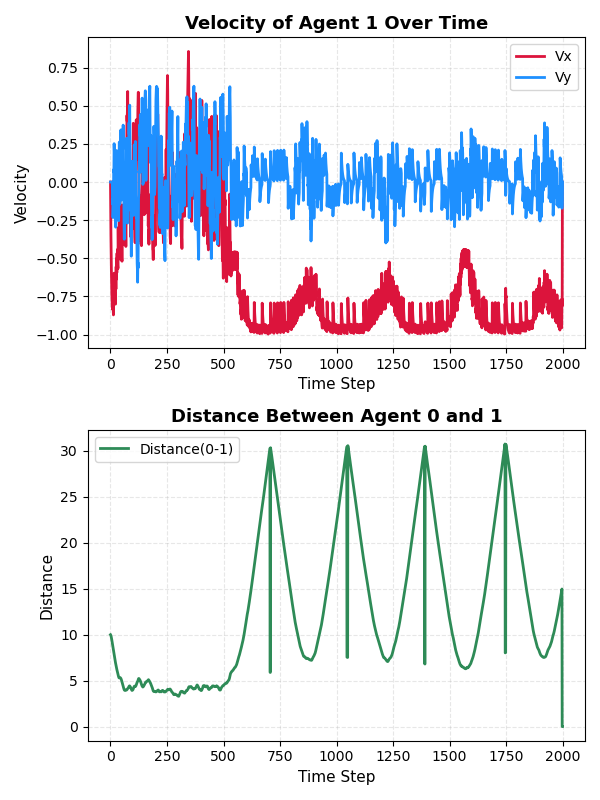

In [135]:
# === Plotting Velocity and Interagent Distance (Portrait Layout) ===
plt.figure(figsize=(6, 8))  # Taller figure for portrait

# --- Top Tile: Velocity of Agent 1 ---
plt.subplot(2, 1, 1)
plt.plot(
    [vel[0, 0, t] for t in range(T)],
    color='crimson', label='Vx', linewidth=2
)
plt.plot(
    [vel[0, 1, t] for t in range(T)],
    color='dodgerblue', label='Vy', linewidth=2
)
plt.title("Velocity of Agent 1 Over Time", fontsize=13, weight='bold')
plt.xlabel("Time Step", fontsize=11)
plt.ylabel("Velocity", fontsize=11)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)

# --- Bottom Tile: Interagent Distance (Agent 0 and 1) ---
plt.subplot(2, 1, 2)
plt.plot(
    [dist[0, 1, t] for t in range(T)],
    color='seagreen', label='Distance(0-1)', linewidth=2
)
plt.title("Distance Between Agent 0 and 1", fontsize=13, weight='bold')
plt.xlabel("Time Step", fontsize=11)
plt.ylabel("Distance", fontsize=11)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


Plotting and saving

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 6))

# Initial scatter with dummy positions and fixed colors
scat = ax.scatter([0, 0], [0, 0], s=200, c=['red', 'blue'], edgecolors='k', alpha=0.85)
title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=14)

# Legend handles
red_patch = mpatches.Patch(color='red', label='<--')
blue_patch = mpatches.Patch(color='blue', label='-->')
ax.legend(handles=[red_patch, blue_patch], loc='upper right')

def init():
    ax.set_xlim(-S, S)
    ax.set_ylim(-S, S)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect("equal")
    return scat, title

def update(t):
    scat.set_offsets(pos[:, :, t])
    title.set_text(f"Agent Positions at t={t*dt:.1f}s. \n isactinfing={isactinfinggrand} \n isplanning={isplanning}")
    return scat, title

ani = FuncAnimation(fig, update, frames=T, init_func=init, blit=True, interval=50)

writer = FFMpegWriter(fps=20, metadata=dict(artist='Active Inference'))
ani.save("agent_positions.mp4", writer=writer)
plt.close()

print("✅ Video saved as 'agent_positions.mp4'")


✅ Video saved as 'agent_positions.mp4'


### Moving Towards Active Inference

### Defining States and Actions

Current agent's state would be the measure of contributions of F $(F^{res})$ restitution and F repulsion $(F^{res})$. 

$d=\frac{|F^{rep}|}{|F^{res}|}$.

We currently consider just the mag, directions we can extend later.

Aggent desires two things in a preference order:
- Agent Desires d to be minimum,
- At the minimum, v0 must be it's intrinsic one, say $eta$

actions: changes preferred direction $\hat{e}0$
- DEFAULT: Changes $\hat{e}0$ to the default value, say $\eta$
- SLIGHT R : Change $\hat{e}0$ slightly
- MAJOR : Change $\hat{e}0$ significantly
<!-- - EXTREME: Turn Back -->

### States

| State       | Condition on $d$        |
|-------------|-------------------------|
| Desired     | $0 \leq d < 5$          |
| Mild        | $5 \leq d < 30$         |
| Significant | $30 \leq d \leq 100$    |




### Actions

| Action Label | Action Effect|
|------------|---------------|
| DEFAULT | $\hat{e}_0 \rightarrow \eta$ |
| Mild Left (ML)| $\hat{e}_0\rightarrow\hat{e}_0-45^\circ$|
| Mild Right (MR)| $\hat{e}_0\rightarrow\hat{e}_0+45^\circ$|
| Significant Left (SL) | $\hat{e}_0\rightarrow\hat{e}_0-90^\circ$|
| Significant Right (SR)| $\hat{e}_0\rightarrow\hat{e}_0+90^\circ$|

In [137]:
states=["DESIRED","MILD","SIGNIFICANT"]
actions=["DEFAULT","ML","MR","SL","SR"]

## **Building the generative model**: $\mathbf{A}$, $\mathbf{B}$, $\mathbf{C}$, and $\mathbf{D}$

### 1. The **A** matrix or $P(o\mid s)$. 

---

The generative model's "prior beliefs" about how hidden states relate to observations

In [138]:
""" Create variables for the storing the dimensionalities of the hidden states and the observations """

n_states = len(states)
n_observations = len(states)

print(f'Dimensionality of hidden states: {n_states}')
print(f'Dimensionality of observations: {n_observations}')

Dimensionality of hidden states: 3
Dimensionality of observations: 3


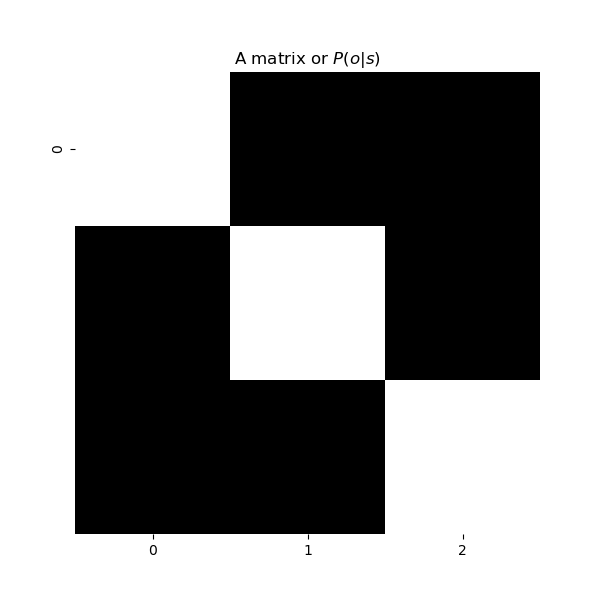

In [139]:
""" Create the A matrix  """

A = np.zeros( (n_states, n_observations) )

""" Create an umambiguous or 'noise-less' mapping between hidden states and observations """

np.fill_diagonal(A, 1.0)

plot_likelihood(A,xlabels=range(n_states),ylabels=(n_states), title_str = "A matrix or $P(o|s)$")
# alternative:
# A = np.eye(n_observations, n_states)

### 2. The **B** matrix or $P(s_{t}\mid s_{t-1}, u_{t-1})$.


---

The generative model's "prior beliefs" about (controllable) transitions between hidden states over time. Namely, how do hidden states at time $t$ result from hidden states at some previous time $t-1$. These transition dynamics are further conditioned on some past action $u_t$.

In [140]:
for i in actions:
    print(f"if action_label==\"{i}\":")

if action_label=="DEFAULT":
if action_label=="ML":
if action_label=="MR":
if action_label=="SL":
if action_label=="SR":


In [141]:
A[[0,1],1]=2
A

array([[1., 2., 0.],
       [0., 2., 0.],
       [0., 0., 1.]])

[[[0. 1. 1. 1. 1.]
  [0. 1. 1. 1. 1.]
  [0. 1. 1. 1. 1.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


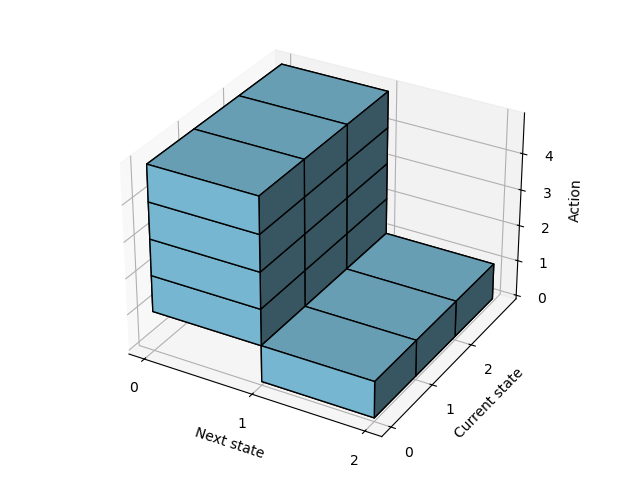

In [142]:

def create_B_matrix(i,t,debugging=False):
  B = np.zeros( (len(states), len(states), len(actions)) )
  pos_temp=np.copy(pos)
  vel_temp=np.copy(vel)
  acc_temp=np.copy(acc)
  pref_vel_temp=np.copy(pref_vel)
  
  
  for action_id, action_label in enumerate(actions):

    # for curr_state, state_label in enumerate(states):
          # if state_label=="DESIRED":
      if action_label=="DEFAULT":
                      
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,0]
        if debugging:
          print(pref_vel_temp[i,1,0]/np.pi)
        
        
      if action_label=="ML":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]+np.pi/4
        
      if action_label=="MR":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]-np.pi/4
        
      if action_label=="SL":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]+np.pi/2
        
      if action_label=="SR":
        pref_vel_temp[i,1,t]=pref_vel_temp[i,1,t-1]-np.pi/2
              
          # if state_label=="MILD":
          #   if action_label=="DEFAULT":
              
          #   if action_label=="ML":
              
          #   if action_label=="MR":
              
          #   if action_label=="SL":
              
          #   if action_label=="SR":
              
          # if state_label=="SIGNIFICANT":
          #   if action_label=="DEFAULT":
              
          #   if action_label=="ML":
              
          #   if action_label=="MR":
              
          #   if action_label=="SL":
              
          #   if action_label=="SR":
      if debugging:     
        print(pref_vel_temp[i,:,t]/np.pi)   
      acc_temp[:,:,t]=acc_intrinsic(vel_temp,pref_vel_temp,i,t)+acc_repulsive(pos_temp,i,t-1)
      update_simulation(acc_temp,vel_temp,pos_temp,t)
      next_state = states.index(get_state_label(acc_intrinsic(vel_temp,pref_vel_temp,i,t),acc_repulsive(pos_temp,i,t)))
      B[next_state, :, action_id] = 1.0
  return B

B = create_B_matrix(0,20)
print(B)
plot_B_matrix(B)

### 3. The prior over observations: the $\mathbf{C}$ vector or $\tilde{P}(o)$

---

The (biased) generative model's prior preference for particular observations, encoded in terms of probabilities.


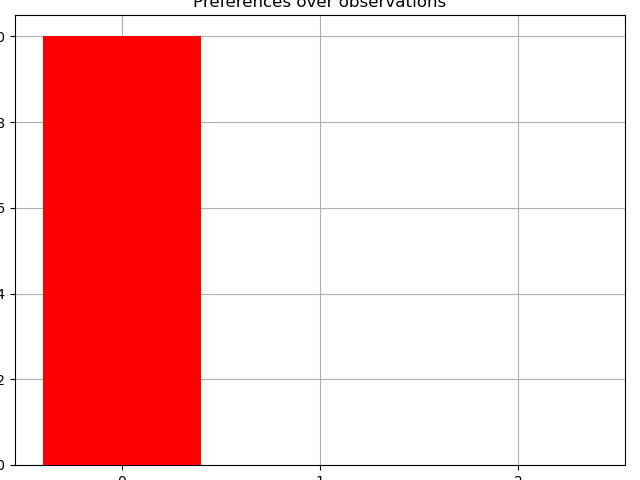

In [143]:
""" Create an empty vector to store the preferences over observations """
C = np.zeros(n_observations)

""" Choose an observation index to be the 'desired' rewarding index, and fill out the C vector accordingly """
desired_state = "DESIRED" # choose a desired location
desired_index = states.index(desired_state) # get the linear index of the grid location, in terms of 0 through 8


C[desired_index] = 1.0 # set the preference for that location to be 100%, i.e. 1.0
plt.clf()
"""  Let's look at the prior preference distribution """
plot_beliefs(C, title_str = "Preferences over observations")

### 3. The prior over hidden states: the $\mathbf{D}$ vector or $P(s)$

---

The generative model's prior belief over hidden states at the first timestep.


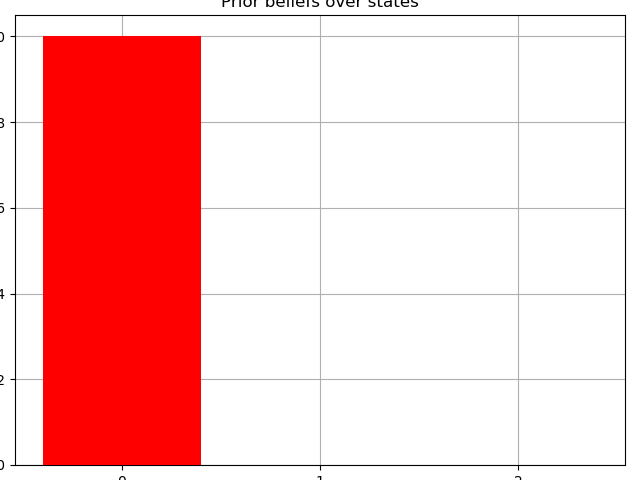

In [144]:
""" Create a D vector, basically a belief that the agent has about its own starting location """

# create a one-hot / certain belief about initial state

D = utils.onehot(0, n_states)

# demonstrate hwo belief about initial state can also be uncertain / spread among different possible initial states
# alternative, where you have a degenerate/noisy prior belief
# D = utils.norm_dist(np.ones(n_states))

""" Let's look at the prior over hidden states """
plot_beliefs(D, title_str = "Prior beliefs over states")